# Data Science from Scratch
- https://www.oreilly.com/library/view/data-science-from/9781491901410/?afsrc=1
- Joel Grus

#### Link Dump
* [math in markdown](http://csrgxtu.github.io/2015/03/20/Writing-Mathematic-Fomulars-in-Markdown/)
* [seaborn distributions](http://seaborn.pydata.org/tutorial/distributions.html)

## Terms
- Type I error - false positive
- Type II error - false negative

## Hypothesis Testing

### Coin Flip

$H_0 = p(heads) = 0.5$

$H_1 = p(heads) \neq 0.5$

In [22]:
from typing import Tuple
import math
import matplotlib.pyplot as plt

def normal_cdf(x: float, mu: float = 0, sigma: float = 1) -> float:
    return (1+ math.erf((x - mu) / math.sqrt(2) / sigma)) / 2

normal_probability_below = normal_cdf

def normal_approximation_to_binomial(n: int, p:float) -> Tuple[float,float]:
    mu = p*n
    sigma = math.sqrt(p * (1-p) * n)
    return mu, sigma

# It's above the threshold if it's not below the threshold
def normal_probability_above(lo: float,
                             mu: float = 0,
                             sigma: float = 1) -> float:
    """The probability that an N(mu, sigma) is greater than lo."""
    return 1 - normal_cdf(lo, mu, sigma)

# It's between if it's less than hi, but not less than lo
def normal_probability_between(lo: float,
                               hi: float,
                               mu: float = 0,
                               sigma: float = 1) -> float:
    """The probability that an N(mu, sigma) is between lo and hi."""
    return normal_cdf(hi, mu, sigma) - normal_cdf(lo, mu, sigma)

# It's outside if it's not between
def normal_probability_outside(lo: float,
                               hi: float,
                               mu: float = 0,
                               sigma: float = 1) -> float:
    """The probability that an N(mu, sigma) is not between lo and hi."""
    return 1 - normal_probability_between(lo, hi, mu, sigma)

def inverse_normal_cdf(p: float,
                       mu: float = 0,
                       sigma: float = 1,
                       tolerance: float = 0.00001) -> float:
    """Find approximate inverse using binary search"""

    # if not standard, compute standard and rescale
    if mu != 0 or sigma != 1:
        return mu + sigma * inverse_normal_cdf(p, tolerance=tolerance)

    low_z = -10.0                      # normal_cdf(-10) is (very close to) 0
    hi_z  =  10.0                      # normal_cdf(10)  is (very close to) 1
    while hi_z - low_z > tolerance:
        mid_z = (low_z + hi_z) / 2     # Consider the midpoint
        mid_p = normal_cdf(mid_z)      # and the CDF's value there
        if mid_p < p:
            low_z = mid_z              # Midpoint too low, search above it
        else:
            hi_z = mid_z               # Midpoint too high, search below it

    return mid_z

def normal_upper_bound(probability: float,
                       mu: float = 0,
                       sigma: float = 1) -> float:
    """Returns the z for which P(Z <= z) = probability"""
    return inverse_normal_cdf(probability, mu, sigma)

def normal_lower_bound(probability: float,
                       mu: float = 0,
                       sigma: float = 1) -> float:
    """Returns the z for which P(Z >= z) = probability"""
    return inverse_normal_cdf(1 - probability, mu, sigma)

def normal_two_sided_bounds(probability: float,
                            mu: float = 0,
                            sigma: float = 1) -> Tuple[float, float]:
    """
    Returns the symmetric (about the mean) bounds
    that contain the specified probability
    """
    tail_probability = (1 - probability) / 2

    # upper bound should have tail_probability above it
    upper_bound = normal_lower_bound(tail_probability, mu, sigma)

    # lower bound should have tail_probability below it
    lower_bound = normal_upper_bound(tail_probability, mu, sigma)

    return lower_bound, upper_bound

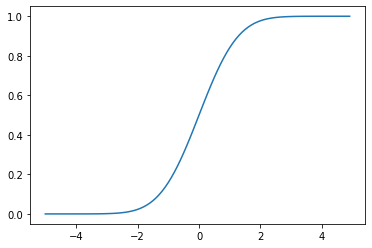

In [23]:
xs = [x / 10.0 for x in range(-50, 50)]
plt.plot(xs, [normal_cdf(x, sigma=1) for x in xs])

In [24]:
mu_0, sigma_0 = normal_approximation_to_binomial(1000, 0.5)
(mu_0, sigma_0)
# (500.0, 15.811388300841896)
# This says: if the probability of head is 0.5 in 1000 flips, then we should see an average of 500 heads
# +/- 15 is one standard deviation

(500.0, 15.811388300841896)

In [25]:
normal_two_sided_bounds(0.95, mu_0, sigma_0)
# (469.0325870513916, 530.9674129486084)
# This gives you the bounds for 95% of the results you'd expect
# from flipping a fair coin 1000 times (mu = 500)

(469.01026640487555, 530.9897335951244)

### Test Power

In [26]:
# 95% bounds based on assumption p is 0.5
lo, hi = normal_two_sided_bounds(0.95, mu_0, sigma_0)
print("lo={}, hi={}".format(lo, hi))

# actual mu and sigma based on p = 0.55
mu_1, sigma_1 = normal_approximation_to_binomial(1000, 0.55)
print("mu_1={}, sigma_1={}".format(mu_1, sigma_1))

# a type 2 error means we fail to reject the null hypothesis,
# which will happen when X is still in our original interval
type_2_probability = normal_probability_between(lo, hi, mu_1, sigma_1)
power = 1 - type_2_probability      # 0.887

lo=469.01026640487555, hi=530.9897335951244
mu_1=550.0, sigma_1=15.732132722552274


In [27]:
normal_probability_between(lo, hi, mu_1, sigma_1)

0.11345199870463285

### P-Values

In [28]:
def two_sided_p_value(x: float, mu: float = 0, sigma: float = 1) -> float:
    """
    How likely are we to see a value at least as extreme as x (in either
    direction) if our values are from an N(mu, sigma)?
    """
    if x >= mu:
        # x is greater than the mean, so the tail is everything greater than x
        return 2 * normal_probability_above(x, mu, sigma)
    else:
        # x is less than the mean, so the tail is everything less than x
        return 2 * normal_probability_below(x, mu, sigma)

In [29]:
two_sided_p_value(469, 500, 15.8)

0.04975953687404899

In [30]:
# So with a mean of 500 and a stdev of 15.8
# the probability of seeing a value at least as extreme as 529.5 (so: include 530)
# is 0.062
two_sided_p_value(529.5, mu_0, sigma_0)

0.06207721579598835

In [47]:
import random

extreme_value_count = 0
for _ in range(1000):
    num_heads = sum(1 if random.random() < 0.5 else 0    # Count # of heads
                    for _ in range(1000))                # in 1000 flips,
    if num_heads >= 530 or num_heads <= 470:             # and count how often
            extreme_value_count += 1                         # the # is 'extreme'

    # p-value was 0.062 => ~62 extreme values out of 1000
assert 59 < extreme_value_count < 65, f"EVC: {extreme_value_count}"

AssertionError: EVC: 69

In [32]:
print(extreme_value_count)

60


### A/B Testing

$N_A =$ Count of people seeing Treatment A

$n_A =$ Count of people clicking Treatment A

$P_a = n_A / N_A$ 

$\sigma_A = \sqrt{P_A \times (1 - P_A) / N_A}$

In [34]:
import math

def estimated_parameters(N: int, n: int):
    p = n / N
    sigma = math.sqrt(p * (1 - p) / N)
    return p, sigma

In [35]:
def a_b_test_statistic(N_A: int, n_A: int, N_B: int, n_B: int) -> float:
    p_A, sigma_A = estimated_parameters(N_A, n_A)
    p_B, sigma_B = estimated_parameters(N_B, n_B)
    return (p_B - p_A) / math.sqrt(sigma_A ** 2 + sigma_B ** 2)

In [46]:
two_sided_p_value(a_b_test_statistic(1000, 200, 1000, 160))

0.01973954756993812

In [44]:
estimated_parameters(1000, 200)

(0.2, 0.01264911064067352)

In [45]:
estimated_parameters(1000, 160)

(0.16, 0.01159310139695155)

## Logistic Regression

## K-Means Clustering

## Linear Regression

## Markov Chain Monte Carlo

## Matrices

## Neural Nets